# Future price levels for electricity in Melbourne
## Summary
- Electricity prices are expected to return to at least 2017-2019 levels as the world economy recovers from the COVID pandemic. Thus we can expect an **average price of 102 AUD/ MWh** for Melbourne once the COVID pandemic subsides.
- 

## Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Import and preprocess data

In [2]:
df = pd.read_csv('../data/raw/energy_demand.csv')
column_mapper = {"RRP":"price", 
                 "demand_pos_RRP":"demand_pos_price",
                 "RRP_positive":"price_positive",
                 "demand_neg_RRP":"demand_neg_price",
                 "RRP_negative":"price_negative",
                 "frac_at_neg_RRP":"frac_neg_price"}

df.rename(columns = column_mapper, inplace = True)

# Convert datatypes
df.date = pd.to_datetime(df.date)
df.school_day = df.school_day.map({"N": False, "Y":True}).astype('bool')
df.holiday = df.holiday.map({"N": False, "Y":True}).astype('bool')

# Extract year, month and day of week from data
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['dow'] = df.date.dt.day_of_week

# Convert solar exposure from MJ/m^2 to MWh/m^2 (1 MJ = 1/(60*60) MWh)
df.solar_exposure = df.solar_exposure/3600

# Set date as index so can do resampling using pandas
df.set_index('date', inplace =True)

## Electricity prices in Melbourne Jan 1 2015 - Oct 6 2020
The plot below shows the weekly median RRP for electricity in Melbourne. The range of the price (max - min) is shown by the shaded blue area. Some things to note:
- The price of electricity increased significantly during the first quarter of 2017, and stayed at this level for the next 2.5 years. The increase in price coincides with the closure of the [Hazelwood coal power station](https://en.wikipedia.org/wiki/Hazelwood_Power_Station#Closure_and_decommissioning), shown by the dashed line in the figure. It seems likely that the higher price is due to switching from coal to natural gas which is cleaner but more expensive.
- The price of electricity started going down already before the COVID pandemic started (start of lockdown in Victoria is shown by the dot-dashed line in the figure), and is expected to stay low while economic activity is decreased due to the COVID lockdown. Once the pandemic subsides, the price is likely to go up again as oil, gas and coal producers struggle to keep up with demand, having decreased production during the pandemic.
- Seasonal variations in electricity prices are not easily discernible in the data. The seasons do have an effect as shown later, but it is masked by the effect of other factors (probably variation in the price of fossil fuels).
- There are a number of days in the Australian summer (mostly in January) where the price is 10s of times the median weekly price. This seems to indicate that on very hot days, electricity production in Melbourne is not able to keep up with the demand for air conditioning units working on overdrive. This is good nows from the point of view of solar cell arrays, since they will work very well during sunny summer days.

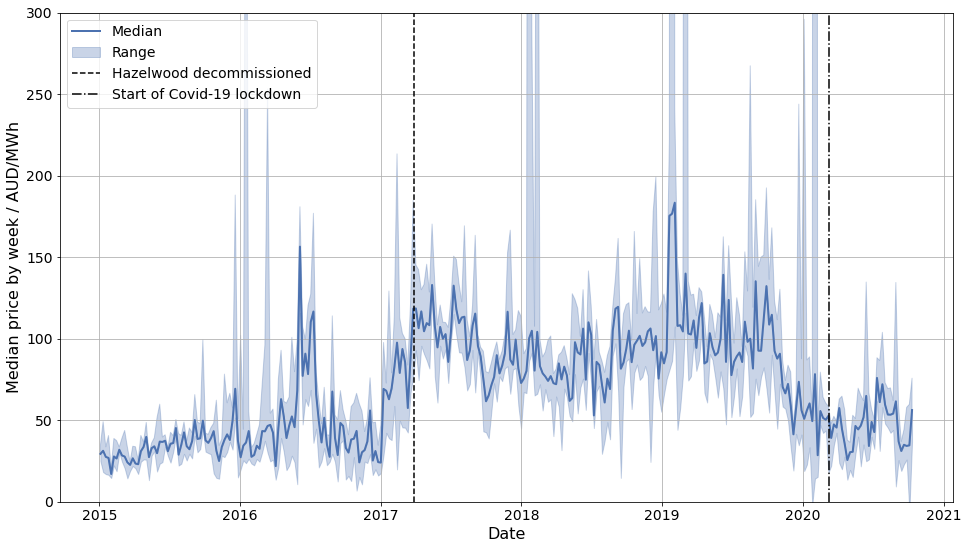

In [3]:
fig, ax = plt.subplots()
sample_window = '1W'
weekly_median = df.resample(sample_window).price.median()
weekly_max = df.resample(sample_window).price.max()
weekly_min = df.resample(sample_window).price.min()

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Median')
ax.fill_between(weekly_median.index, weekly_max, weekly_median, alpha = 0.3, color = 'C0', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_median, alpha = 0.3,  color = 'C0')

ax.axvline(pd.Timestamp('2017-3-29'), ls = '--', c = 'k', label = 'Hazelwood decommissioned')
ax.axvline(pd.Timestamp('2020-3-10'), ls = '-.', c = 'k', label = 'Start of Covid-19 lockdown')

ax.set_ylabel('Median price by week / AUD/MWh')
ax.set_xlabel('Date')
ax.set_ylim([0, 300])
ax.legend()
ax.grid()

Get the average price in during 2017-2019:

In [4]:
print(f"Mean price during 2017, 2018 and 2019: {df['2017-01-01':'2019-12-31'].price.mean():.1f} AUD/MWh")

Mean price during 2017, 2018 and 2019: 102.2 AUD/MWh


## Seasonal variation in prices
### Variation in demand
The plot below shows the seasonal variation in demand for electricity. The average demand is highest during the Australian winter (peaking around June and July), presumbaly due to electrical heating. The highest peak demand, however, is during the summer on very hot days where the need for air conditioning causes a surge.

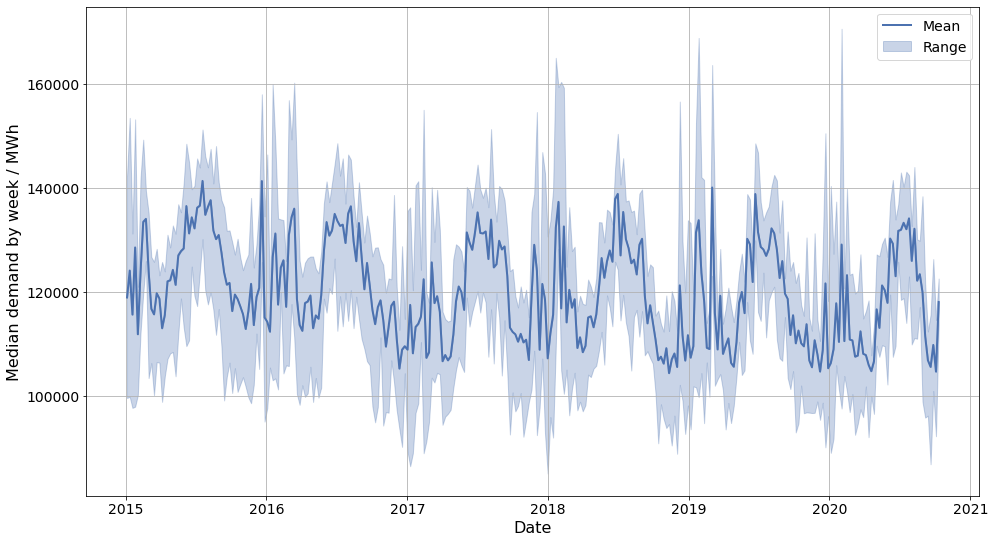

In [5]:
fig, ax = plt.subplots()
sample_window = '1W'
weekly_mean = df.resample(sample_window).demand.mean()
weekly_max = df.resample(sample_window).demand.max()
weekly_min = df.resample(sample_window).demand.min()

ax.plot(weekly_mean.index, weekly_mean, lw = 2, label = 'Mean')
ax.fill_between(weekly_median.index, weekly_max, weekly_mean, alpha = 0.3, color = 'C0', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_mean, alpha = 0.3,  color = 'C0')

ax.set_ylabel('Median demand by week / MWh')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)

### Correlation between demand and price
The plot below shows the correlation between electricity price and demand. Higher demand results in a higher price, as one might expect based on basic economics. The demand explains roughly 25% of the variance in the prices. Since the correlation is fairly weak, the seasonal variations are difficult to see by eye when plotting the price over time, even though the demand has clear seasonal variation.

Correlation coefficient between demand and price: 0.259


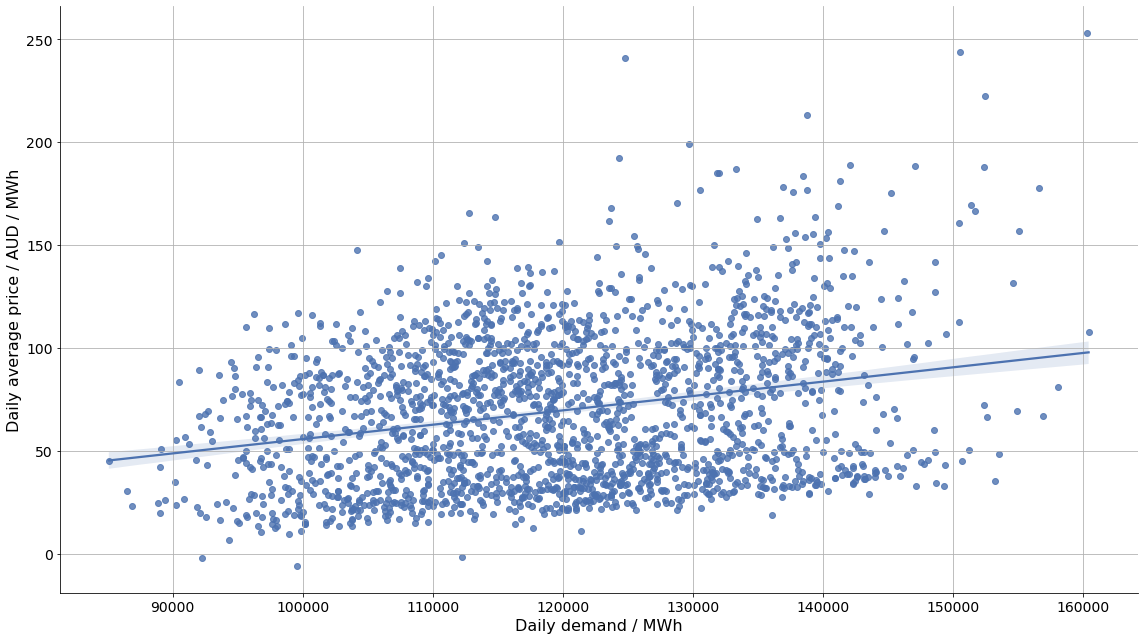

In [6]:
grid = sns.lmplot(data = df[df.price < df.price.median()*4], x = 'demand', y = 'price', height = 9, aspect = 16/9, )
grid.axes[0,0].set_xlabel('Daily demand / MWh')
grid.axes[0,0].set_ylabel('Daily average price / AUD / MWh')
grid.axes[0,0].grid(True)

df_no_outliers = df[df.price < 4*df.price.median()]
corr_coeff = df_no_outliers[['demand']].corrwith(df_no_outliers.price)
print(f"Correlation coefficient between demand and price: {corr_coeff[0]:.3f}")

### Seasonal variation in relative price
To better see the variation in price by season, we can plot the average monthly prices normalized by the average price for the year, as done in the barplot below. 

#### Observations:
- The mean price of electricity is the highest during January. As mentioned before, this is due to days of extreme heat, during which the demand for electricity (probably due to air conditioning) outstrips supply causing prices to surge.
- During the coldest part of the year (June-July), the mean price is also slightly higher than the rest of the year. This is likely due to heating increasing demand for electricity.

Text(0.5, 0, 'Month')

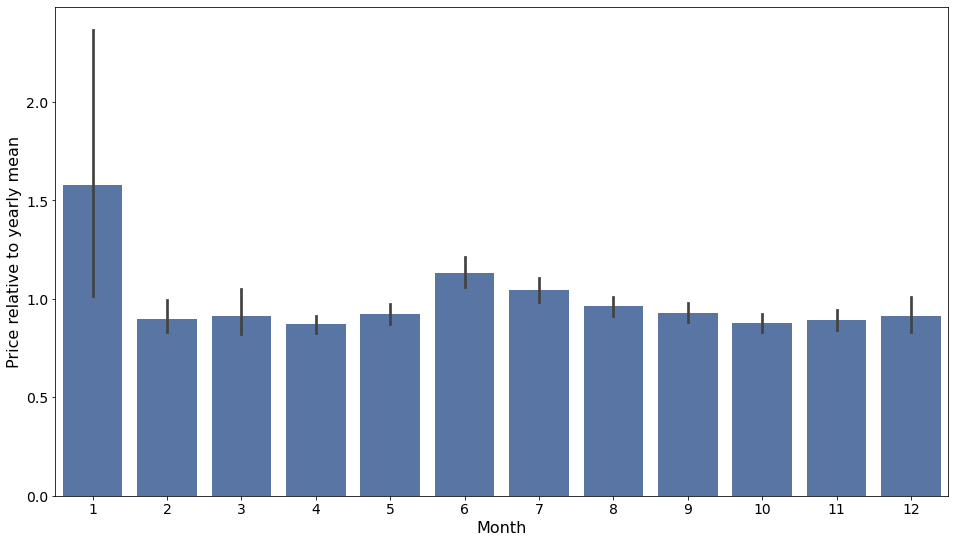

In [7]:
yearly_medians = df.groupby('year').price.mean().to_frame('mean_yearly_price')
df_temp = df.copy()
df_temp = df_temp.merge(yearly_medians, on = 'year')
df_temp['relative_price'] = df_temp.price/df_temp.mean_yearly_price

ax = sns.barplot(data = df_temp, y = 'relative_price', x = 'month', estimator = np.mean, color = 'C0')
ax.set_ylabel('Price relative to yearly mean')
ax.set_xlabel('Month')

Finally, it is useful to know when we might expect demand to outstrip supply, so that that we can make sure to have our batteries charged and solar arrays operational on those days.

The scatterplot below shows the price of energy against the daily maximum temperature. It seems that if the day's maximum temperature exceeds 37 degrees C, there is a possibility of electricity prices surging.

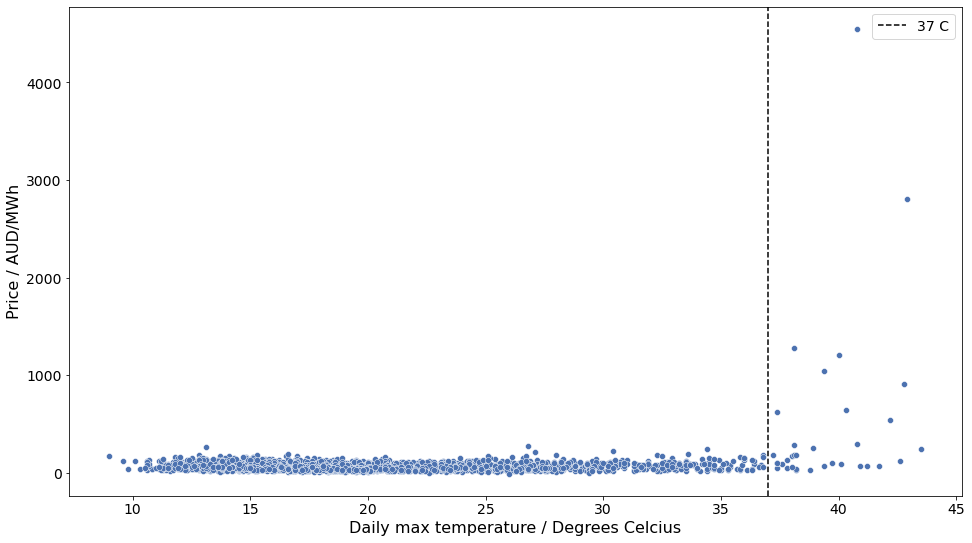

In [8]:
ax = sns.scatterplot(data = df, x = 'max_temperature', y = 'price')
ax.set_ylabel('Price / AUD/MWh')
ax.set_xlabel('Daily max temperature / Degrees Celcius')
ax.axvline(37, ls = '--', c = 'k', label = r'37 C')
ax.legend()

## Seasonal variation in prices and the value of electricity produced by solar arrays
The solar exposure varies greatly during the year in Melbourne, as shown by the plot below. There are also days during the summer when the solar exposure is low, presumably due to cloud cover.

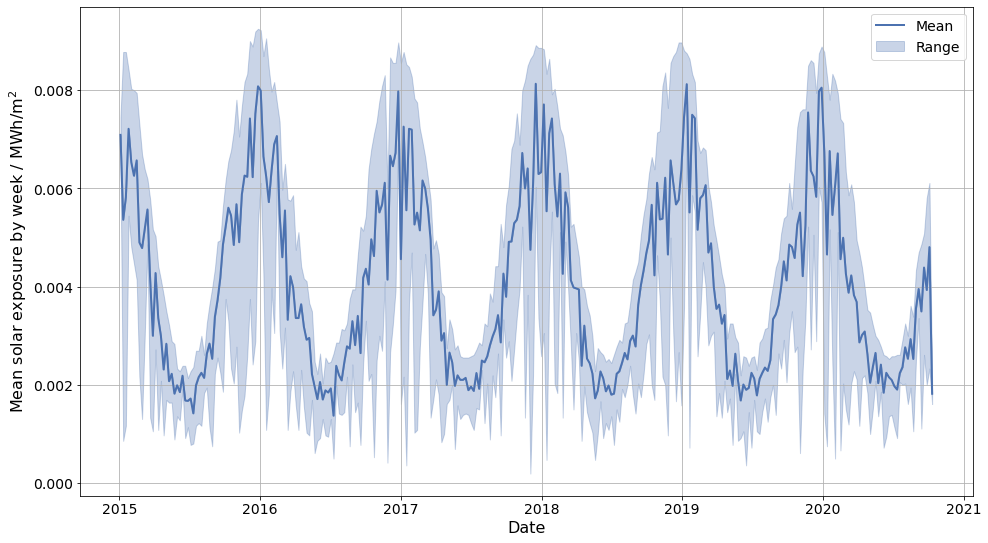

In [9]:
fig, ax = plt.subplots()
sample_window = '1W'
weekly_mean = df.resample(sample_window).solar_exposure.mean()
weekly_max = df.resample(sample_window).solar_exposure.max()
weekly_min = df.resample(sample_window).solar_exposure.min()

ax.plot(weekly_mean.index, weekly_mean, lw = 2, label = 'Mean')
ax.fill_between(weekly_median.index, weekly_max, weekly_mean, alpha = 0.3, color = 'C0', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_mean, alpha = 0.3,  color = 'C0')

ax.set_ylabel(r'Mean solar exposure by week / MWh/m$^2$')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)

Now let's calculate the average value of the electricity produced by a solar array, making the following assumptions:
- Using the prices for 2017-2019 (inclusive)
- Solar array is functional 100% of the time
- All of the electricity is sold at the average daily price (solar power peaks at midday while prices may not so this assumption is probably not true)

The average value of the electricity produced by a solar array is slightly more than the yearly average price since it is mostly produced in the summer where we have peaks in demand: 108.9 AUD/MWh vs 102.2 AUD/MWh.

In [55]:
df_1719 = df['2017-01-01':'2019-12-31']

weighted_average_price = (df_1719.solar_exposure * df_1719.price).sum()/df_1719.solar_exposure.sum()

print(f"Weighted average value of electricity produced by solar array: {weighted_average_price:.1f} AUD/MWh")

Weighted average value of electricity produced by solar array: 108.9 AUD/MWh


### Weekends vs weekdays


## Return on investment
Given that a solar array produces electricity valued at 108.9 AUD/MWh on average, is it actually worth building solar arrays? And how long would it take for a solar array to pay back for itself?

Let's start by calculating the value of the electricity per unit area generated by the solar array over a year:

In [12]:
avg_price = 108.9
PV_efficiency = 0.2
electricity_values = df[df.year != 2020].groupby('year').solar_exposure.sum()*PV_efficiency*avg_price
mean_profit, error_in_mean = electricity_values.mean(), electricity_values.sem()

print(f"Assuming projected average price of {avg_price:.1f} AUD/MWh and solar cell efficiency of {PV_efficiency*100:.1f}%"
      f", mean yearly profit for 2015-2019 is {mean_profit:.1f} +/- {error_in_mean:.1f} AUD/m^2")

Assuming projected average price of 108.9 AUD/MWh and solar cell efficiency of 20.0%, mean yearly profit for 2015-2019 is 33.3 +/- 0.2 AUD/m^2


I can buy a 0.715 m x 0.810 m panel from [HomeDepot](https://images.thdstatic.com/catalog/pdfImages/d3/d30b0bf3-e332-4ba8-852f-80aedabf1c70.pdf) for around $100. Presumably you get a discount if you're buying in bulk so let's say you get a generous 50% discount. The price per square meter is then

In [16]:
discount = 0.5
price = 100
length = 0.810
width = 0.715
panel_cost = (1-discount)*price/(length*width)
print(f"Solar panel cost estimate: {panel_cost:.1f} AUD/m^2")


Solar panel cost estimate: 86.3 AUD/m^2


and the ROI is

In [17]:
print(f"Yearly ROI: {mean_profit/panel_cost*100:.1f} %")

Yearly ROI: 38.6 %


Based on this, a solar array in Melbourne is a great investment. The ROI above does not take into account installation and maintenance costs, or the degradation of the solar panels over time. With these factors included, the costs may go up significantly, and the efficiency of the panels will also lower over time, resulting in smaller profits. However, taking the lifetime of a solar panel to be [25-30 years](https://news.energysage.com/how-long-do-solar-panels-last/), they will have ample time to pay back for themselves (around 10 years, even if we triple the cost per square meter assumed here). 